**Fraud Detection**


Tasks

- Explore the Dataset/Visualise
- Decide which features are important
- Perform Machine Learning
- Test the model on the testing set

# Dependencies

In [0]:
import numpy as np
import sklearn as sk
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

from sklearn.feature_selection import VarianceThreshold

# Kaggle Setup

In [0]:
from google.colab import files

files.upload()

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# we need to set permissions 
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle competitions download -c ieee-fraud-detection

 78% 41.0M/52.5M [00:00<00:00, 55.7MB/s]
100% 52.5M/52.5M [00:00<00:00, 97.1MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 98.8MB/s]
 87% 41.0M/47.3M [00:00<00:00, 42.8MB/s]
100% 47.3M/47.3M [00:00<00:00, 64.8MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 97.6MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 159MB/s]


In [0]:
from zipfile import ZipFile

zf = ZipFile('train_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('train_identity.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_identity.csv.zip', 'r')
zf.extractall()
zf.close()

# Data Preparation

In [0]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
tr_tx = pd.read_csv('train_transaction.csv', low_memory=False)
tr_id = pd.read_csv('train_identity.csv', low_memory=False)
tst_tx = pd.read_csv('test_transaction.csv', low_memory=False)
tst_id = pd.read_csv('test_identity.csv', low_memory=False)

In [0]:
train = pd.merge(tr_tx, tr_id, on='TransactionID', how = 'left')
test = pd.merge(tst_tx, tst_id, on='TransactionID', how = 'left')

In [9]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [10]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
train.shape

(590540, 434)

In [12]:
len(train[train['isFraud']==1])/len(train)*100

3.4990009144173126

# NA Values

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

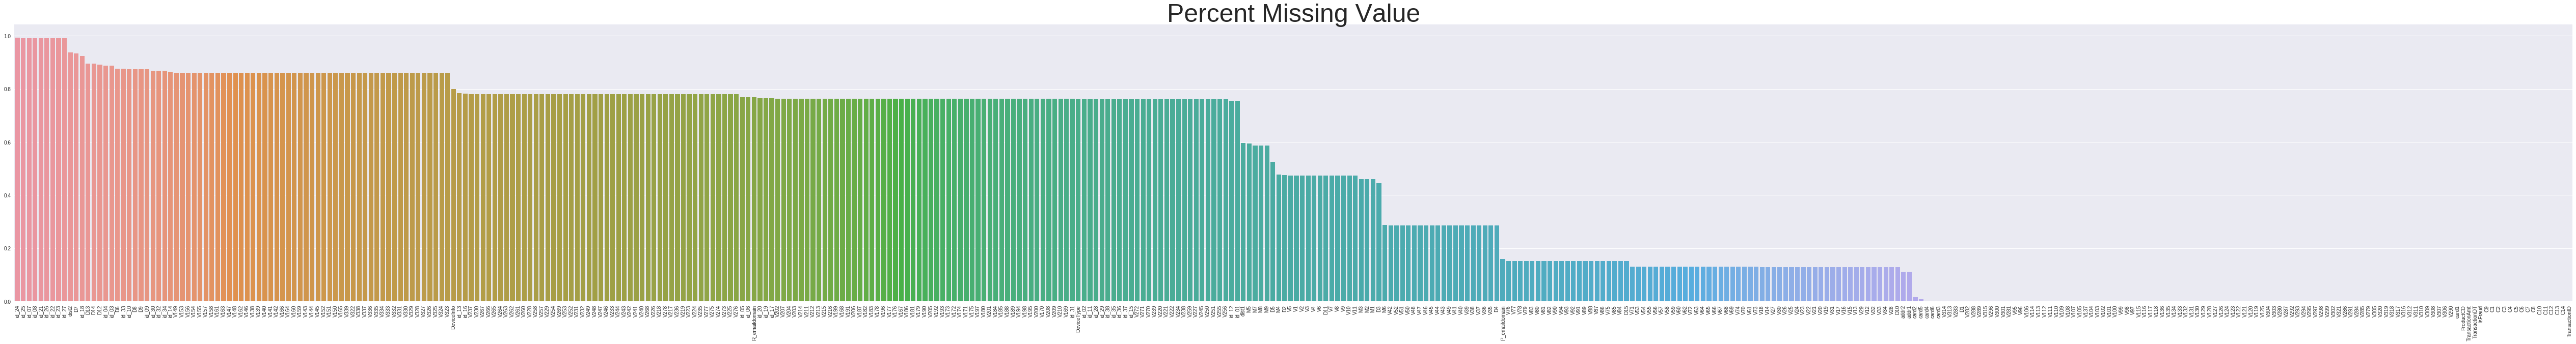

In [13]:
plt.figure(figsize=(90,10))
sns.barplot(y=train.isnull().sum().sort_values(ascending=False)/len(train),
            x=train.isnull().sum().sort_values(ascending=False).index)
plt.title("Percent Missing Value",size=50)
plt.xticks(rotation=90)

In [14]:
columns_def = pd.DataFrame({"na_count":train.isnull().sum().sort_values(ascending=False)})
columns_def["per"]=columns_def["na_count"]/len(train)
columns_def.head(10)

,na_count,per
id_24,585793,0.991962
id_25,585408,0.991310
id_07,585385,0.991271
id_08,585385,0.991271
id_21,585381,0.991264
id_26,585377,0.991257
id_22,585371,0.991247
id_23,585371,0.991247
id_27,585371,0.991247
dist2,552913,0.936284


In [16]:
limit = 0.25
print(columns_def[columns_def["per"]<limit].shape[0]/train.shape[1])

columns_final=columns_def[columns_def["per"]<limit].index
train = train[train.columns.intersection(columns_final)]

train.shape

0.5055555555555555


(590540, 182)

# Categorical Data Transformation

In [18]:
indexes = train.select_dtypes(include=['object']).dtypes.index

for i in indexes:
  print(i, train[i].unique())

ProductCD ['W' 'H' 'C' 'S' 'R']
card4 ['discover' 'mastercard' 'visa' 'american express' nan]
card6 ['credit' 'debit' nan 'debit or credit' 'charge card']
P_emaildomain [nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']


In [0]:
for i in indexes:
  dummy = pd.get_dummies(train[i])
  dummy.head()
  
  train=pd.concat([train,dummy], axis=1)

In [20]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,...,hotmail.com,hotmail.de,hotmail.es,hotmail.fr,icloud.com,juno.com,live.com,live.com.mx,live.fr,mac.com,mail.com,me.com,msn.com,netzero.com,netzero.net,optonline.net,outlook.com,outlook.es,prodigy.net.mx,protonmail.com,ptd.net,q.com,roadrunner.com,rocketmail.com,sbcglobal.net,sc.rr.com,servicios-ta.com,suddenlink.net,twc.com,verizon.net,web.de,windstream.net,yahoo.co.jp,yahoo.co.uk,yahoo.com,yahoo.com.mx,yahoo.de,yahoo.es,yahoo.fr,ymail.com
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,84.0,111.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
train.shape

(590540, 254)

In [0]:
#drop categorical & na
train = train._get_numeric_data()
train = train.dropna()

In [23]:
train.shape

(423710, 250)

In [24]:
len(train[train['isFraud']==1])/len(train)*100

2.0285100658469233

# Visualization

In [0]:
# fraud = train.loc[train['isFraud'] == 1]
# nfraud = train.loc[train['isFraud'] == 0]

# ax = fraud.plot.bar(x='TransactionAmt', y='isFraud', color='Orange', label='Fraud')
# nfraud.plot.bar(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax=ax)
# plt.show()

# Logistic Regression

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score

In [0]:
X = train.drop(["isFraud"], axis=1)
y = train["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [27]:
lr = linear_model.LogisticRegression(solver='lbfgs', max_iter=200)
lr.fit(X_train, y_train)
print('Score: ', lr.score(X_test, y_test))

Score:  0.9799459200668919


In [0]:
y_pred=lr.predict(X_test)

In [29]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,145314,45,145359
1,2929,11,2940
All,148243,56,148299


In [30]:
recall_score(y_test, y_pred)

0.0037414965986394557

In [31]:
accuracy_score(y_test, y_pred)

0.9799459200668919

**TODO**

- look into dropping less Na values
- try other algorithms
- visualize more the data
- research about minimising the crosstab results
- *dig into sklearn feature selection*